In [55]:
import numpy as np
import pandas as pd
import scanpy as sc

In [56]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.8.0


In [57]:
results_file = './NRXN1a.h5ad' # Results file

In [58]:
adata = sc.read_10x_mtx(
    './Data',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/Data-matrix.h5ad


In [59]:
adata.var_names_make_unique()

In [60]:
adata

AnnData object with n_obs × n_vars = 8730 × 33694 
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


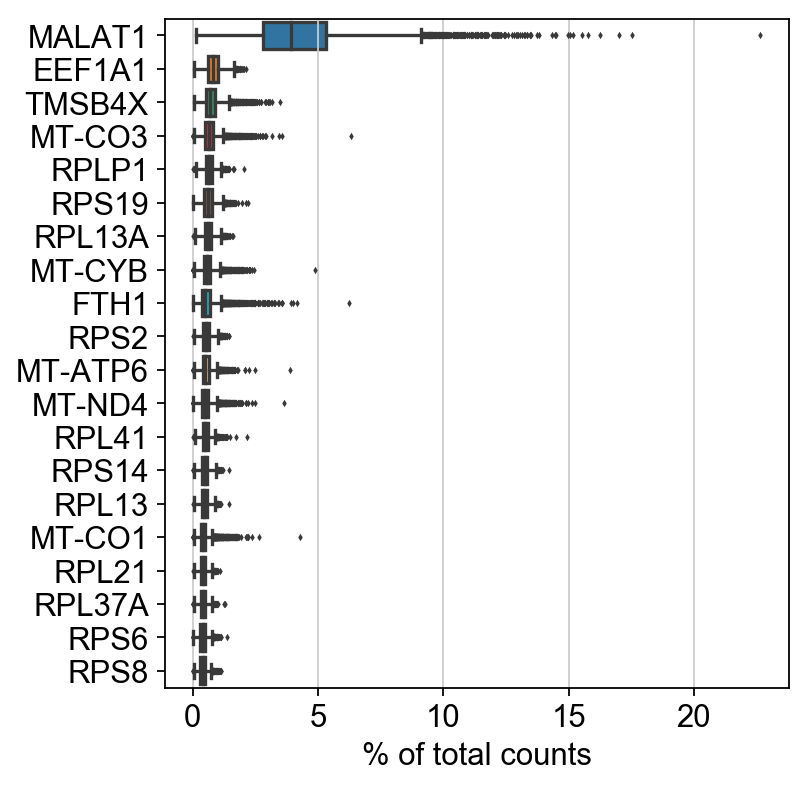

In [61]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [62]:
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3) 

filtered out 13155 genes that are detected in less than 3 cells


In [63]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

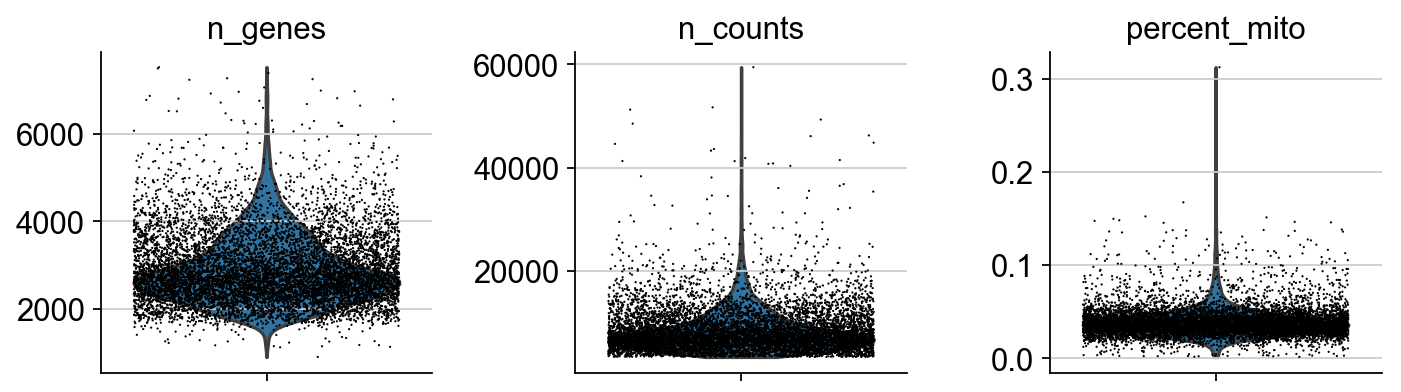

In [64]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

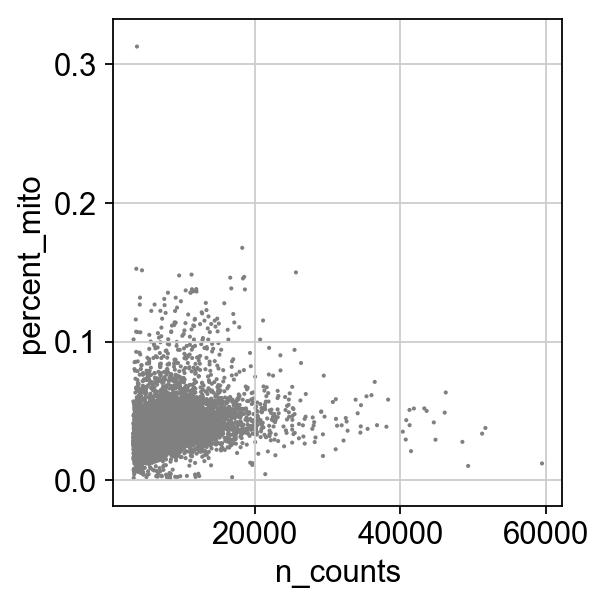

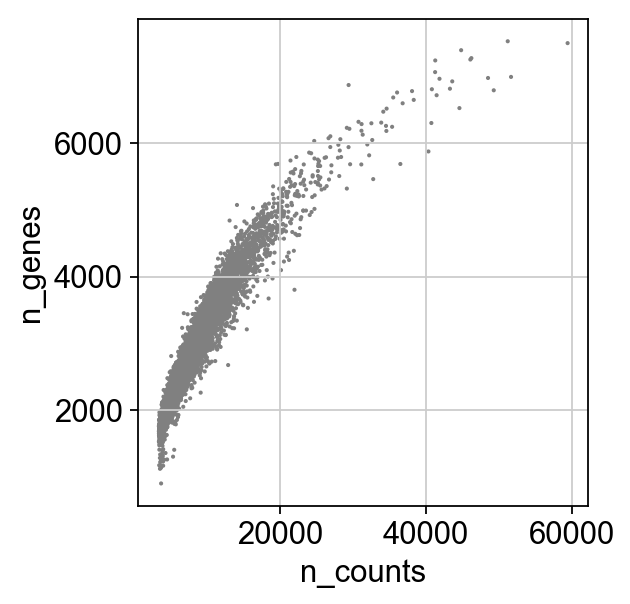

In [65]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [66]:
adata

AnnData object with n_obs × n_vars = 8730 × 20539 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [67]:
adata = adata[adata.obs.n_genes < 2500, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

In [68]:
sc.pp.normalize_total(adata, target_sum=1e4)


normalizing counts per cell
    finished (0:00:03)


In [69]:
sc.pp.log1p(adata)

/Users/nabeelquryshi/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [70]:
#adata.raw = adata

In [71]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


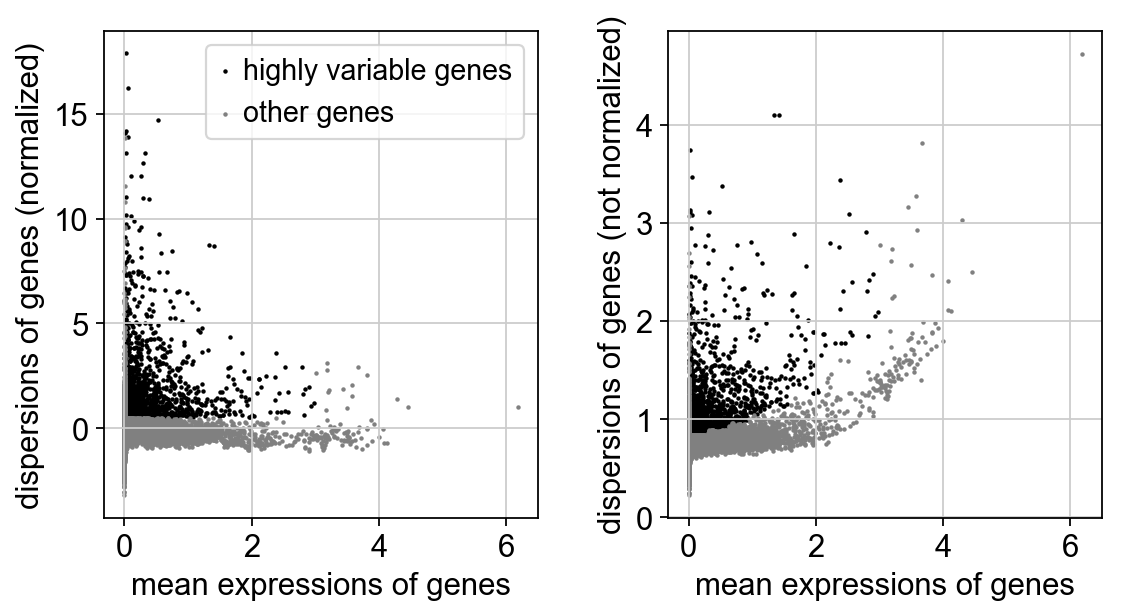

In [72]:
sc.pl.highly_variable_genes(adata)

In [73]:
# adata = adata[:, adata.var.highly_variable]

In [74]:
# sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

In [75]:
# sc.pp.scale(adata, max_value=10)

In [76]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


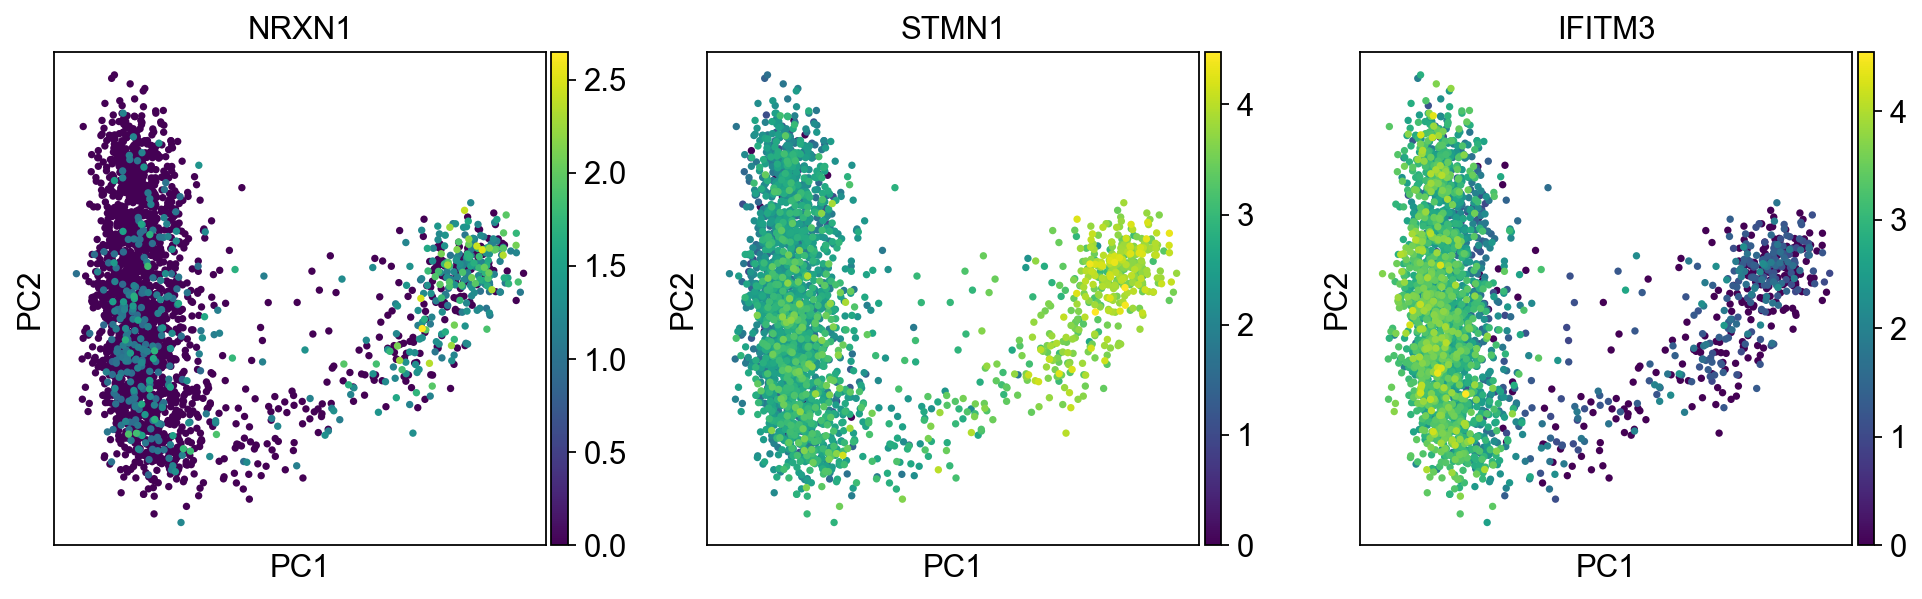

In [158]:
sc.pl.pca(adata, color=['NRXN1','STMN1','IFITM3'])

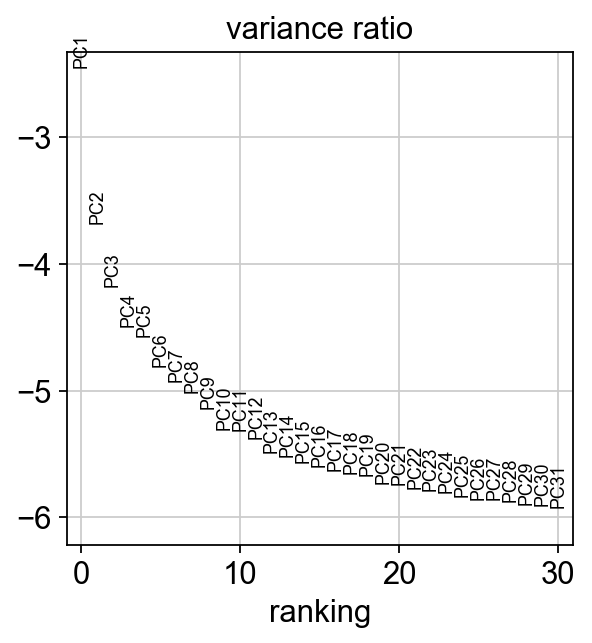

In [78]:
sc.pl.pca_variance_ratio(adata, log=True)

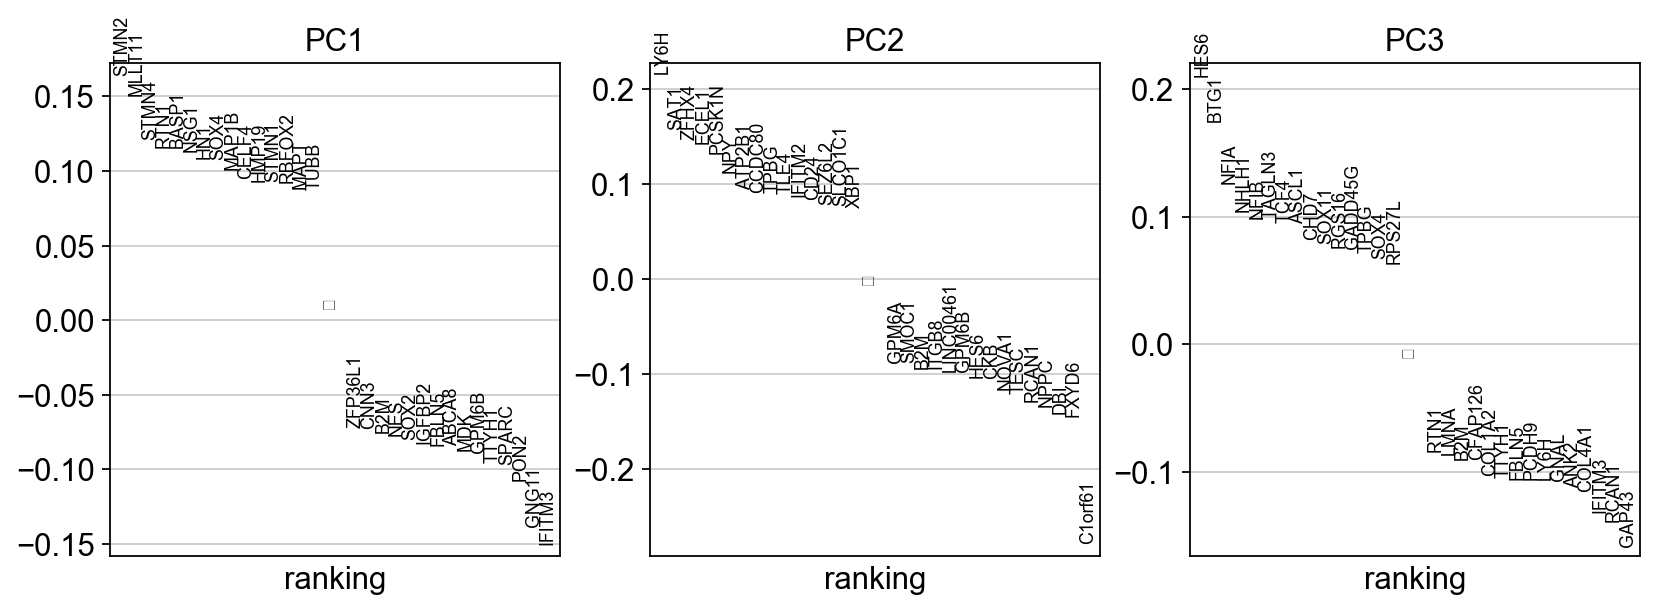

In [156]:
sc.pl.pca_loadings(adata)

In [79]:
adata.write(results_file)

In [80]:
adata

AnnData object with n_obs × n_vars = 2726 × 20539 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [159]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


In [160]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:02)


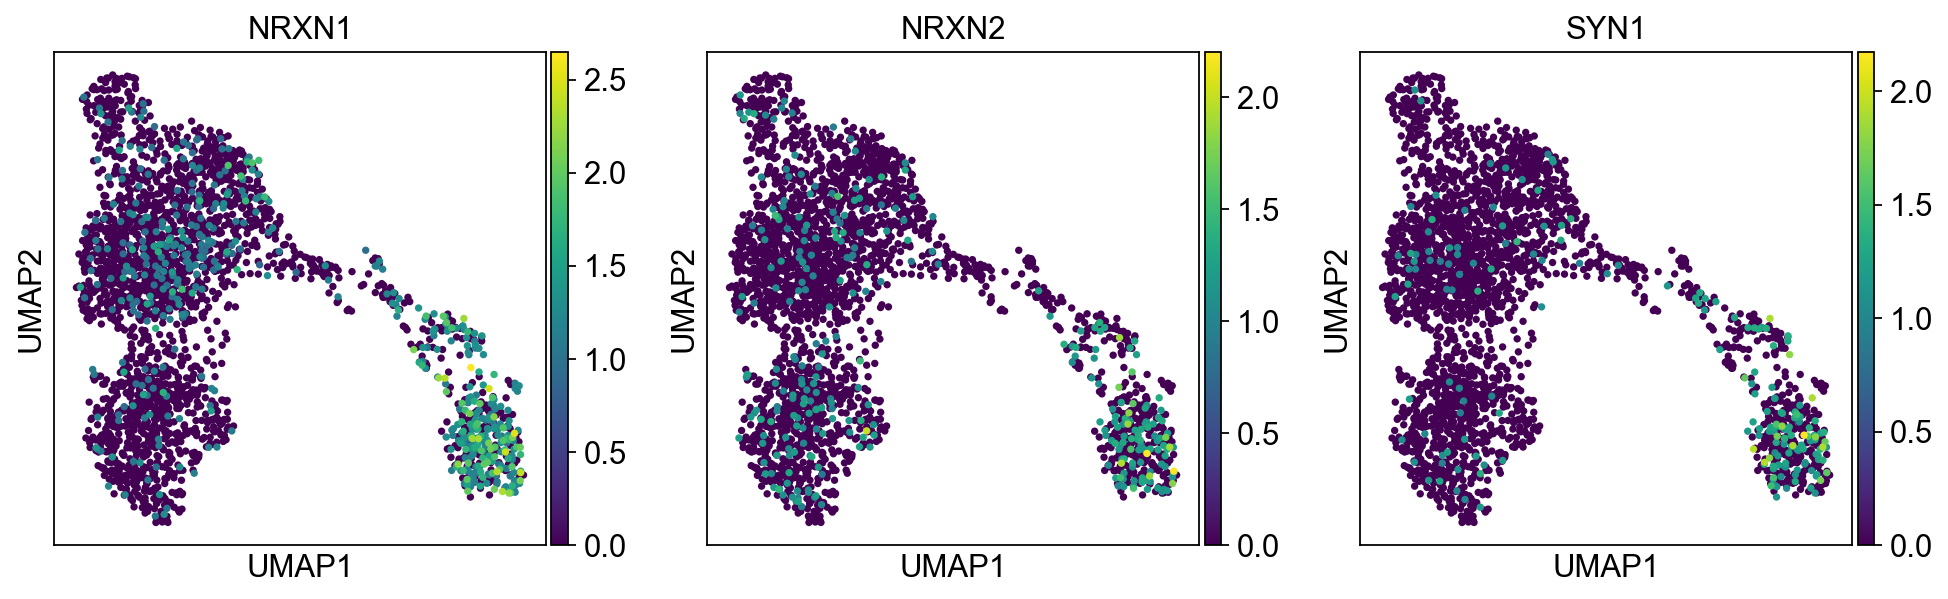

In [161]:
sc.pl.umap(adata, color=['NRXN1','NRXN2','SYN1'])

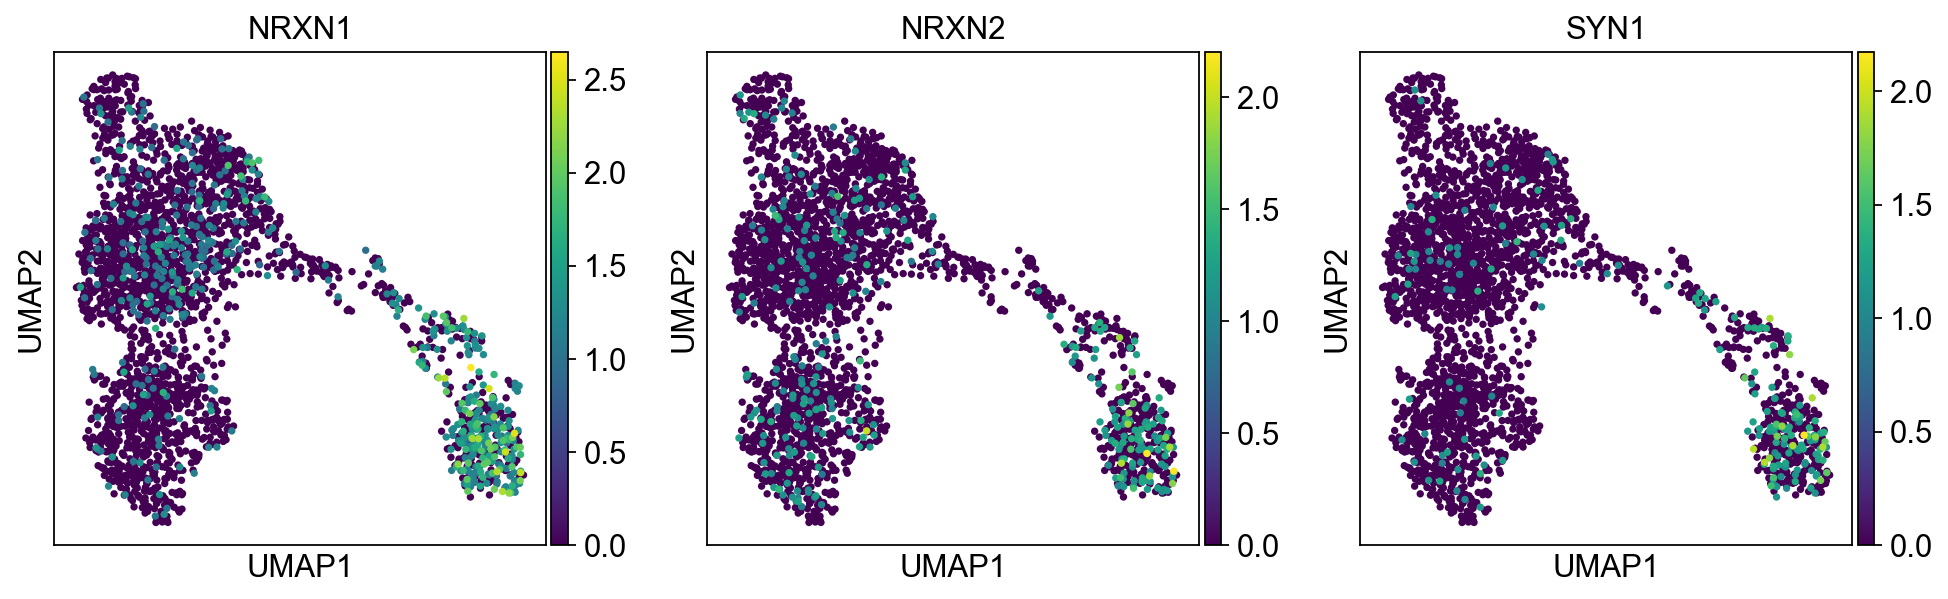

In [163]:
sc.pl.umap(adata, color=['NRXN1','NRXN2','SYN1'], use_raw=False)

In [164]:
sc.tl.leiden(adata)

running Leiden clustering
    finished (0:00:00)


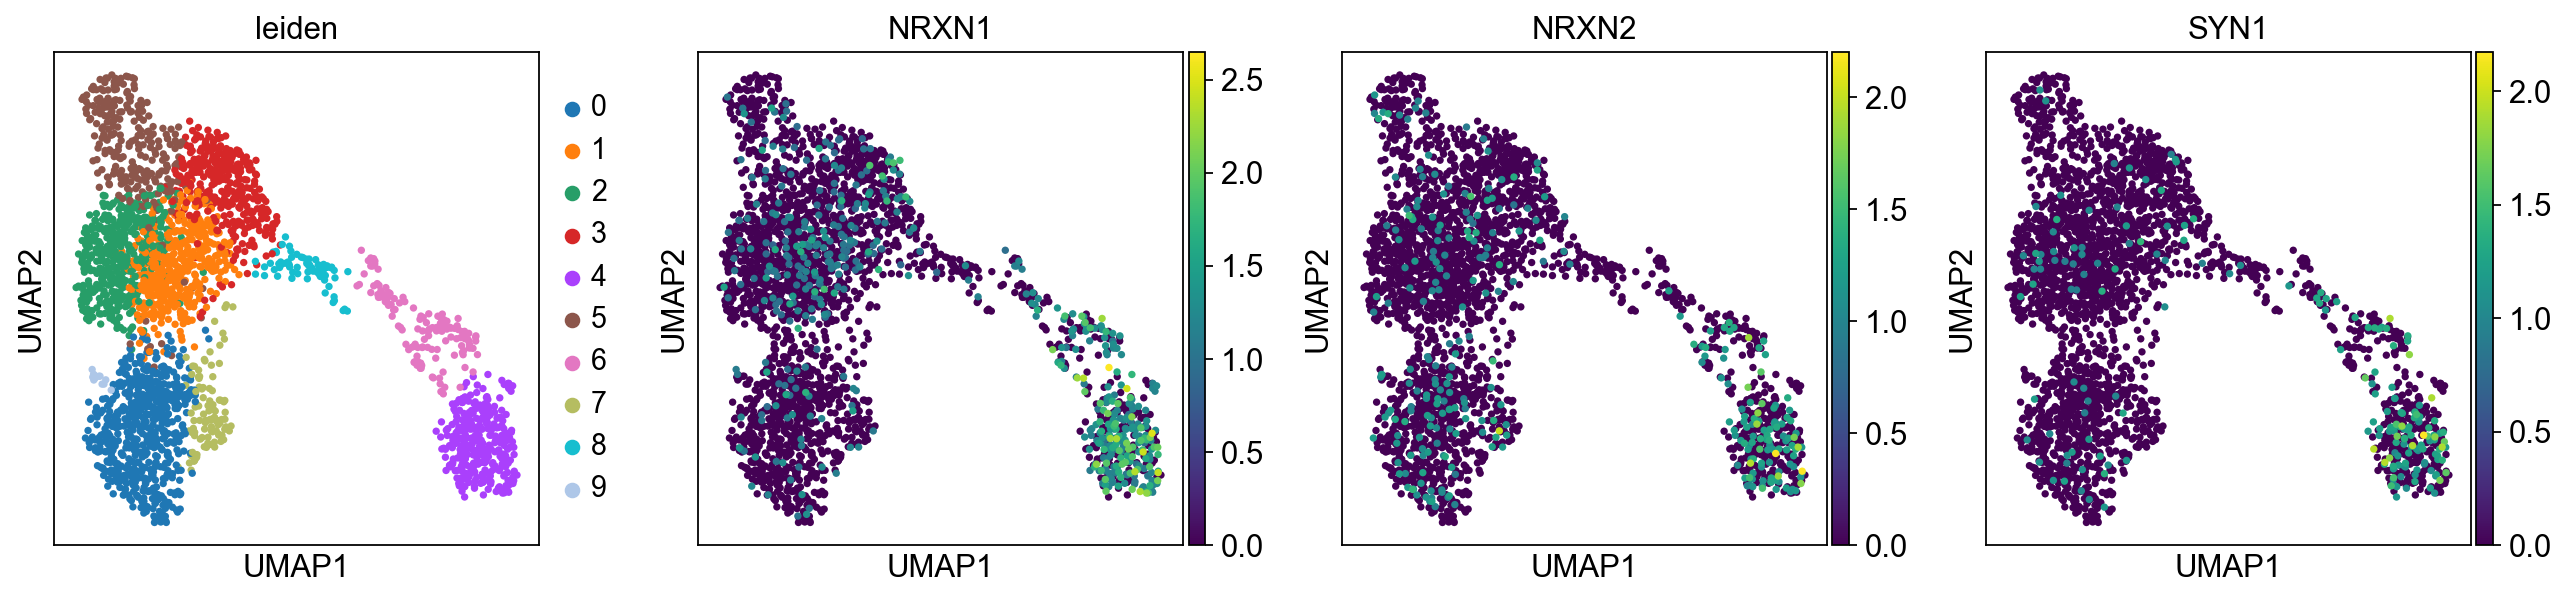

In [165]:
sc.pl.umap(adata, color=['leiden', 'NRXN1','NRXN2','SYN1'])

In [166]:
adata.write(results_file)

ranking genes
    finished (0:00:00)


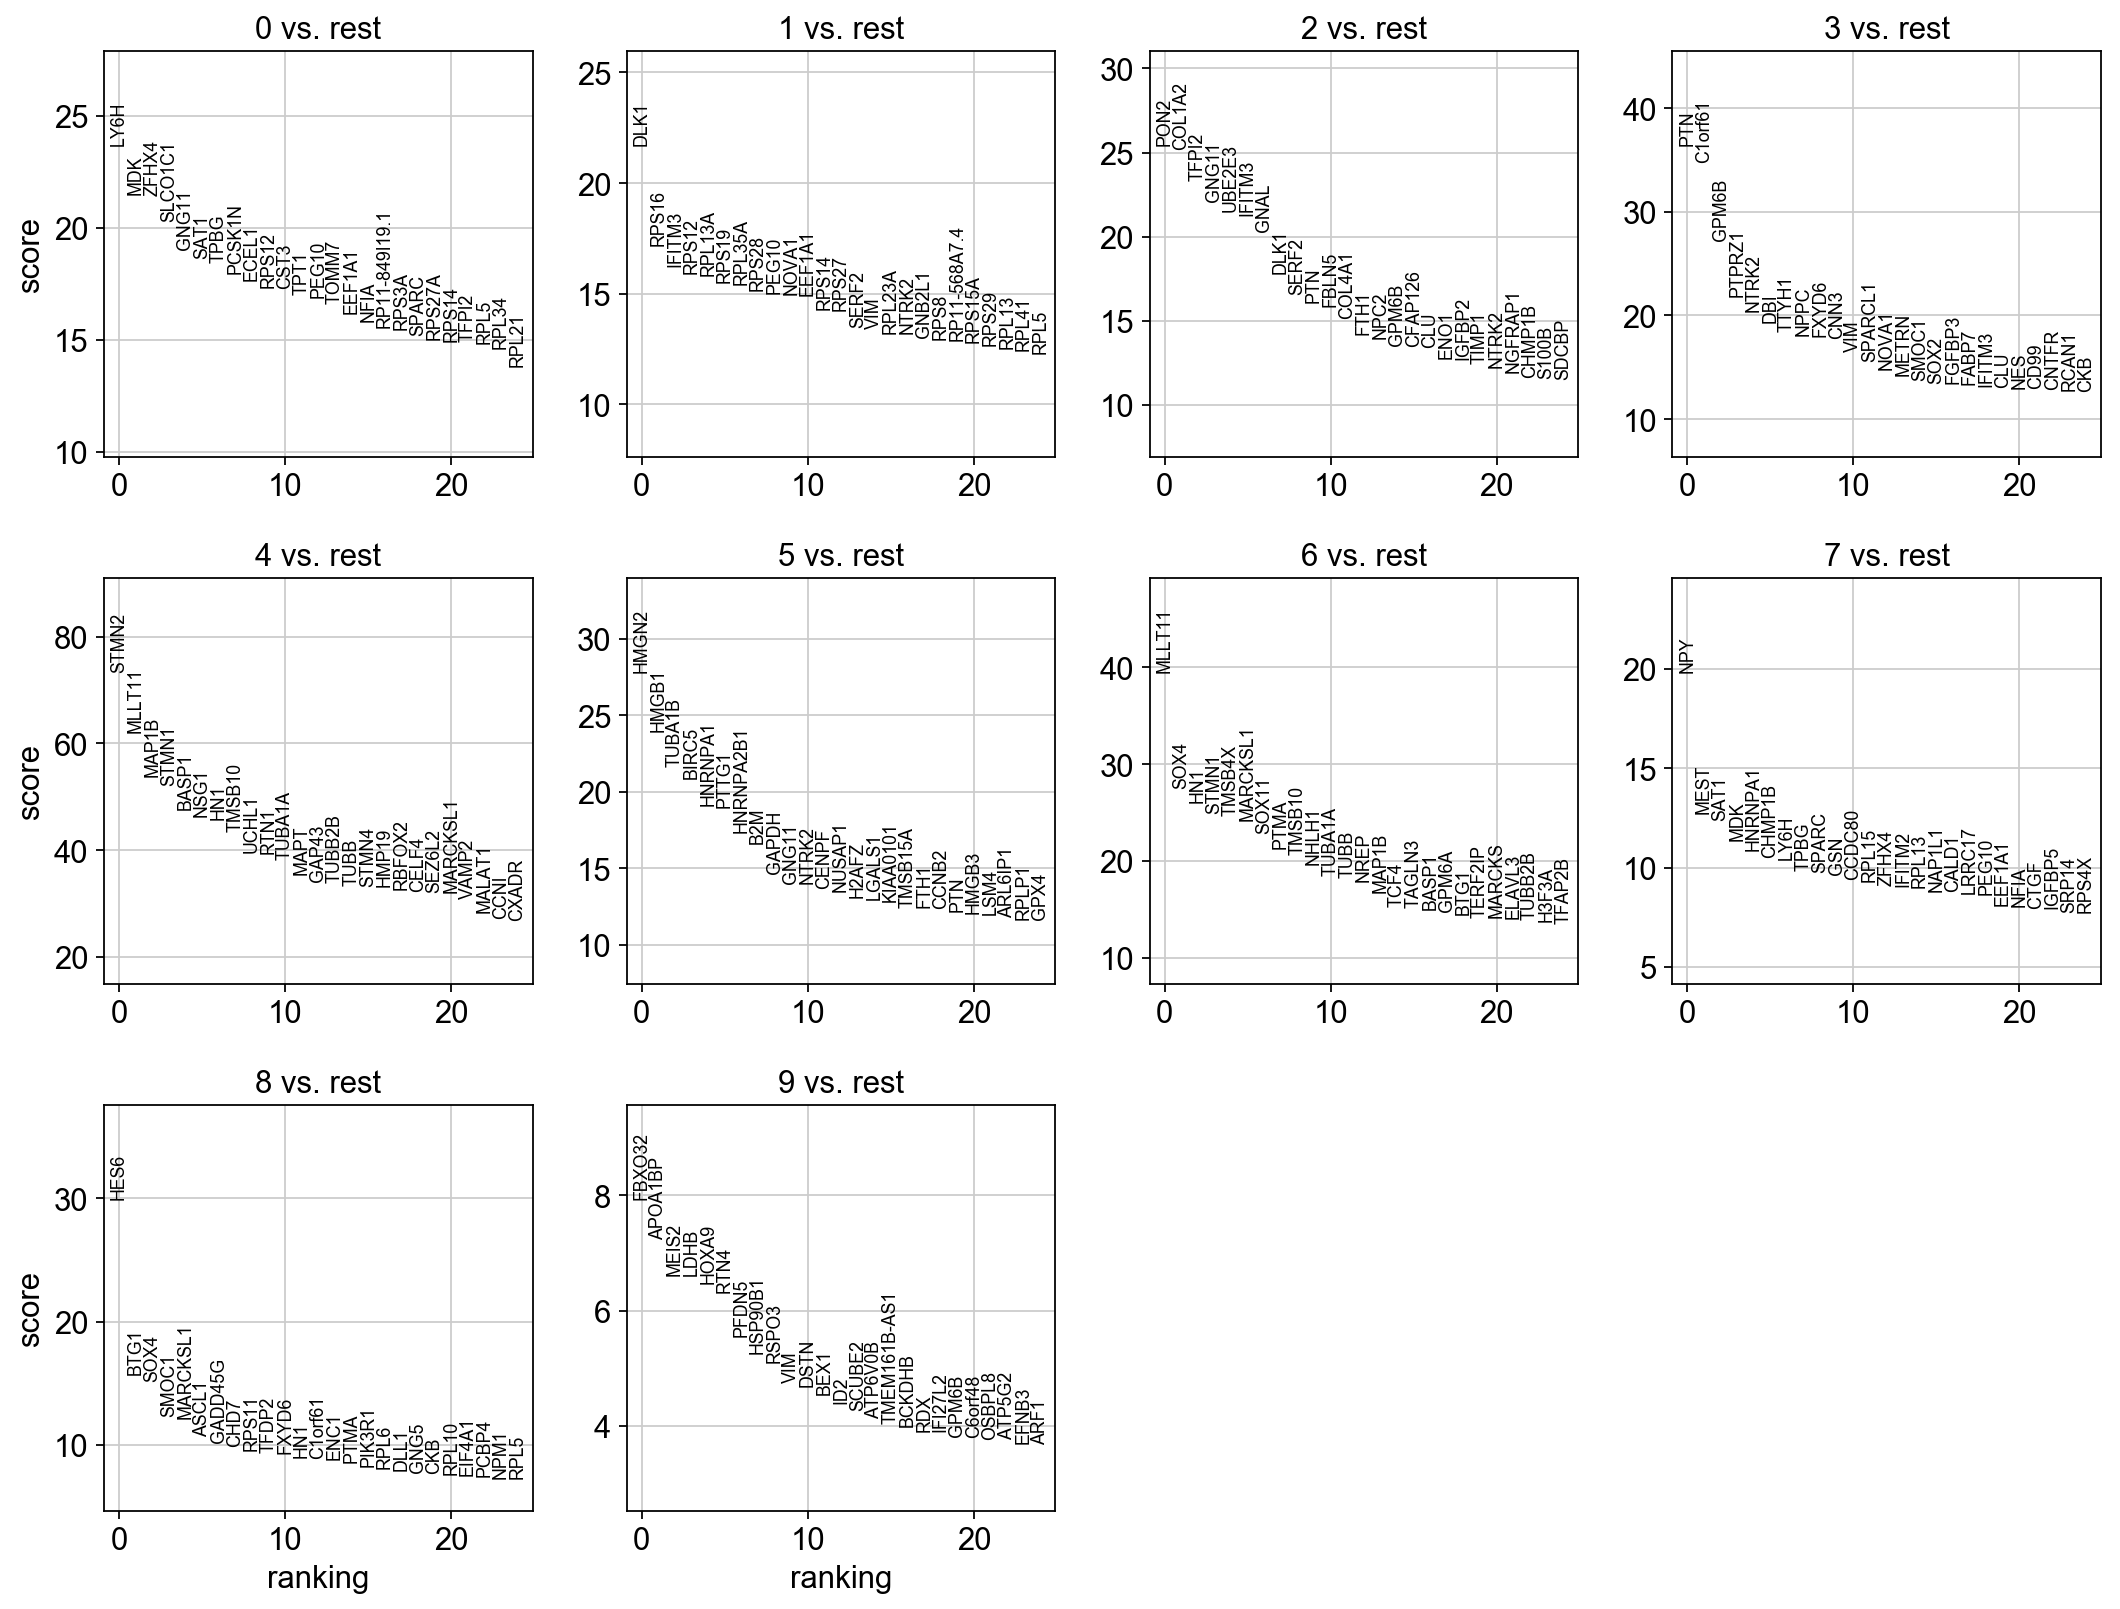

In [167]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [176]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:04)


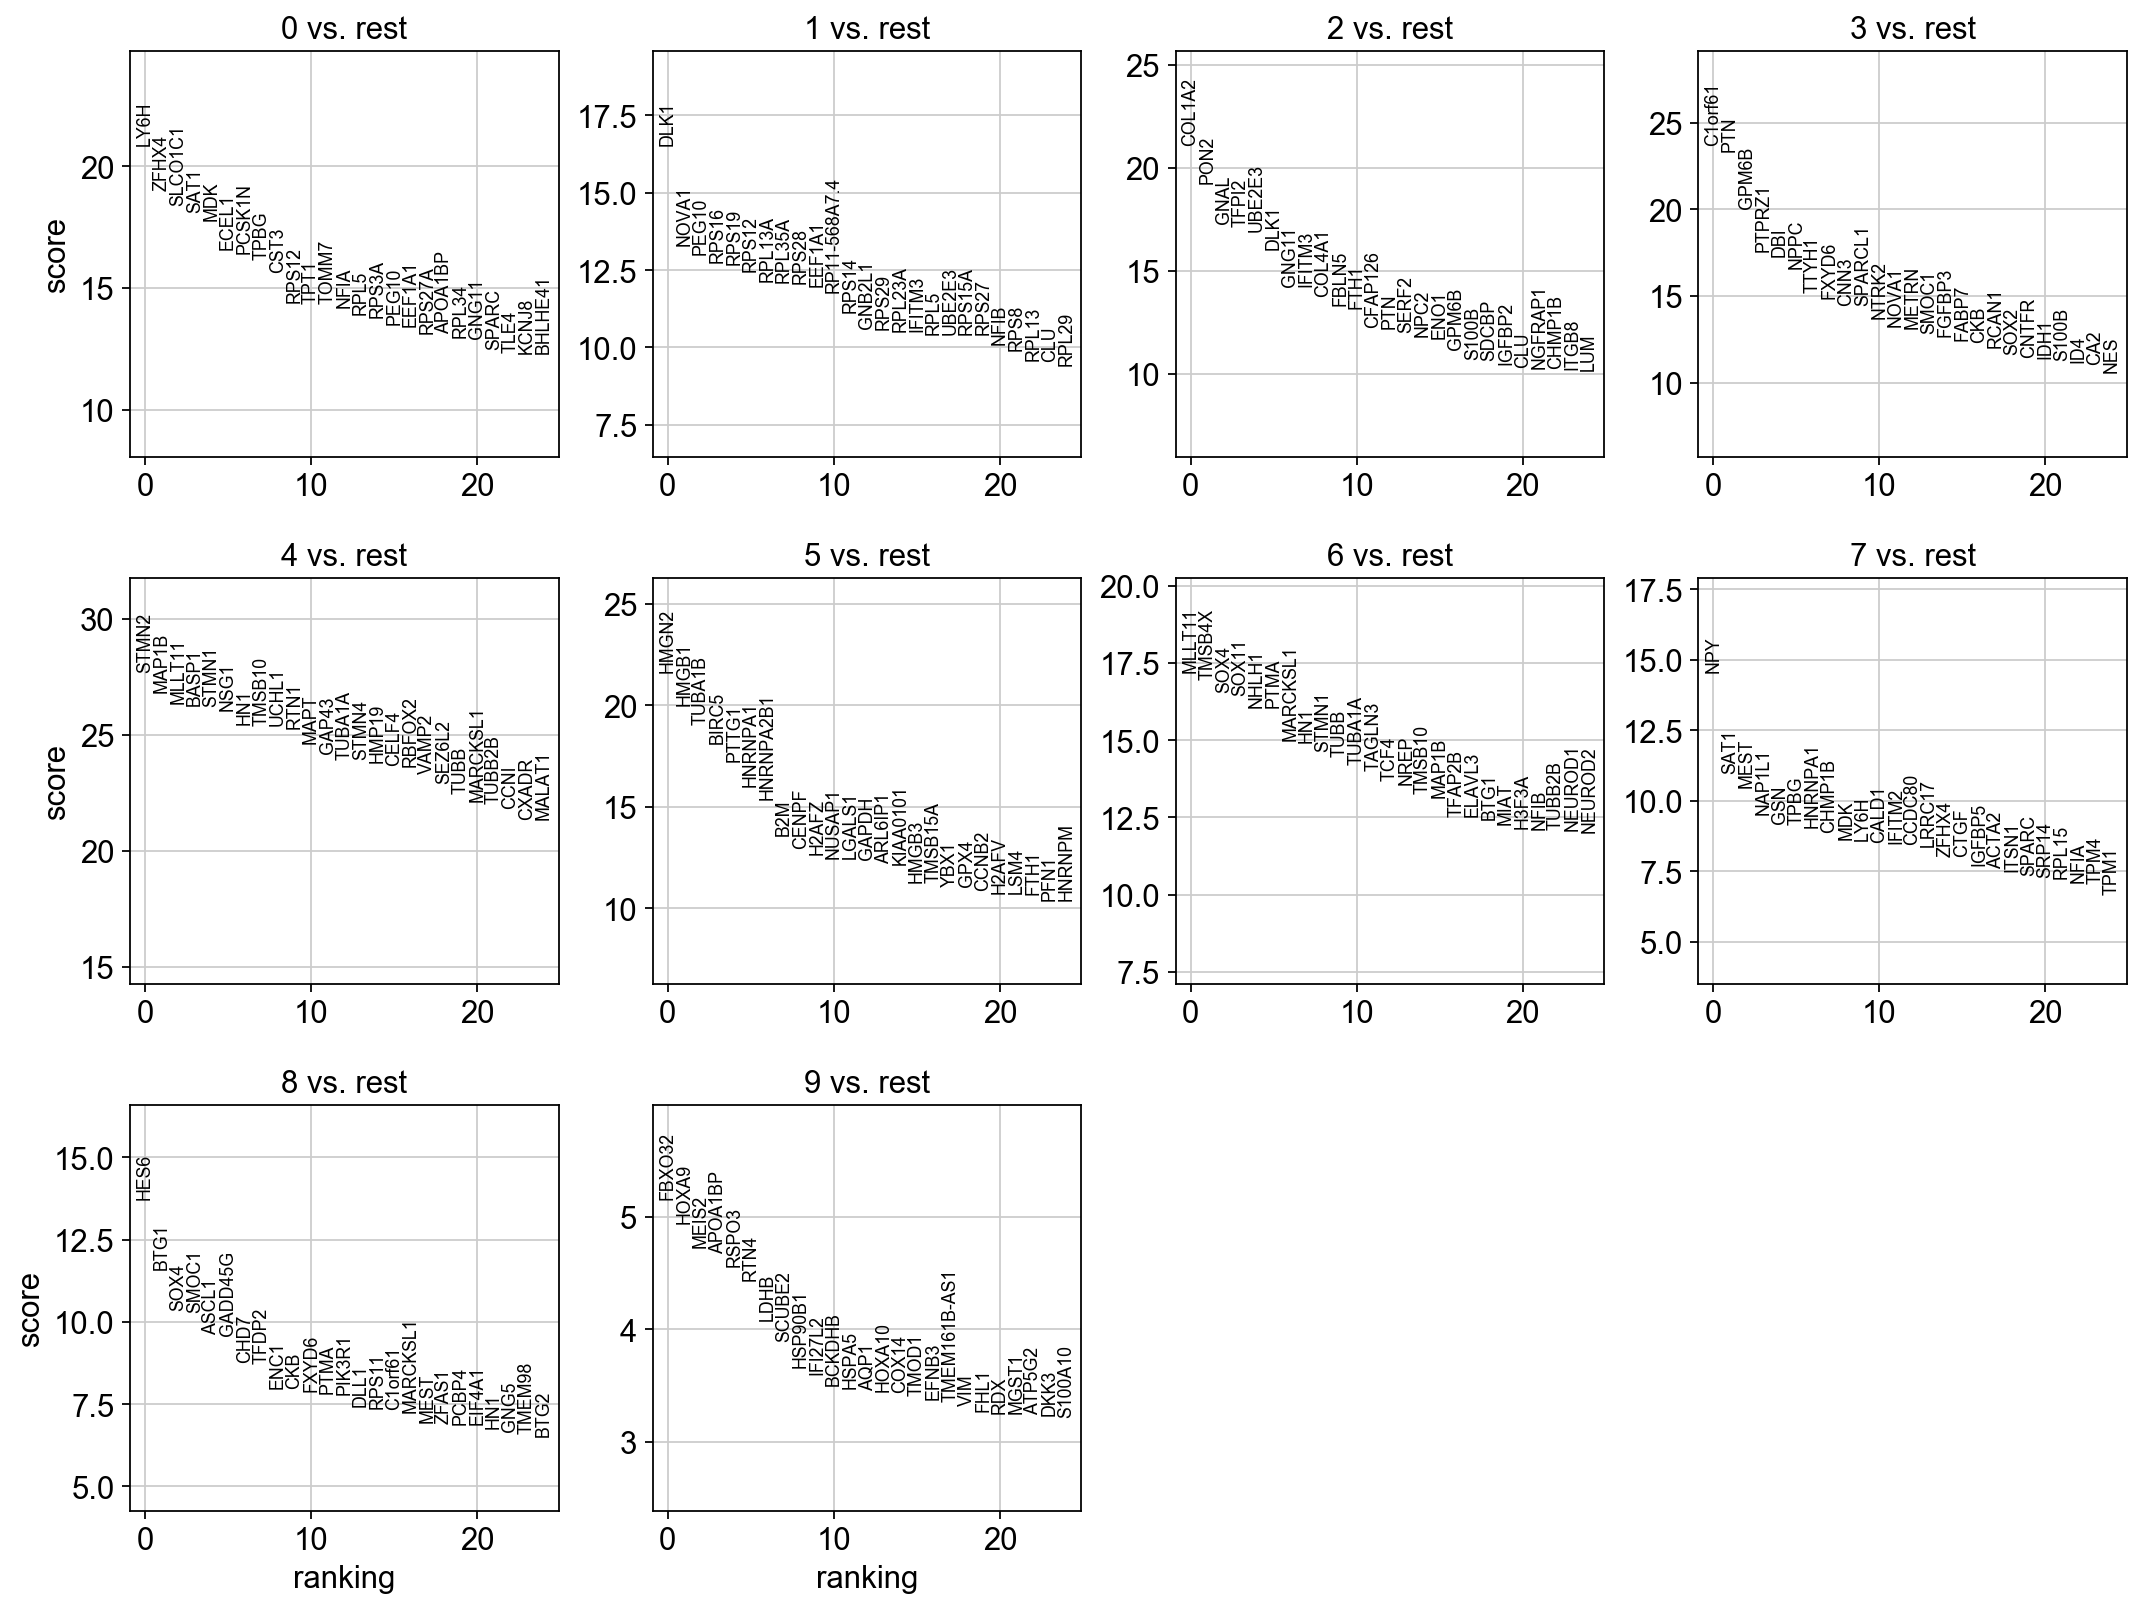

In [177]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [178]:
adata.write(results_file)

ranking genes
    finished (0:00:14)


/Users/nabeelquryshi/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


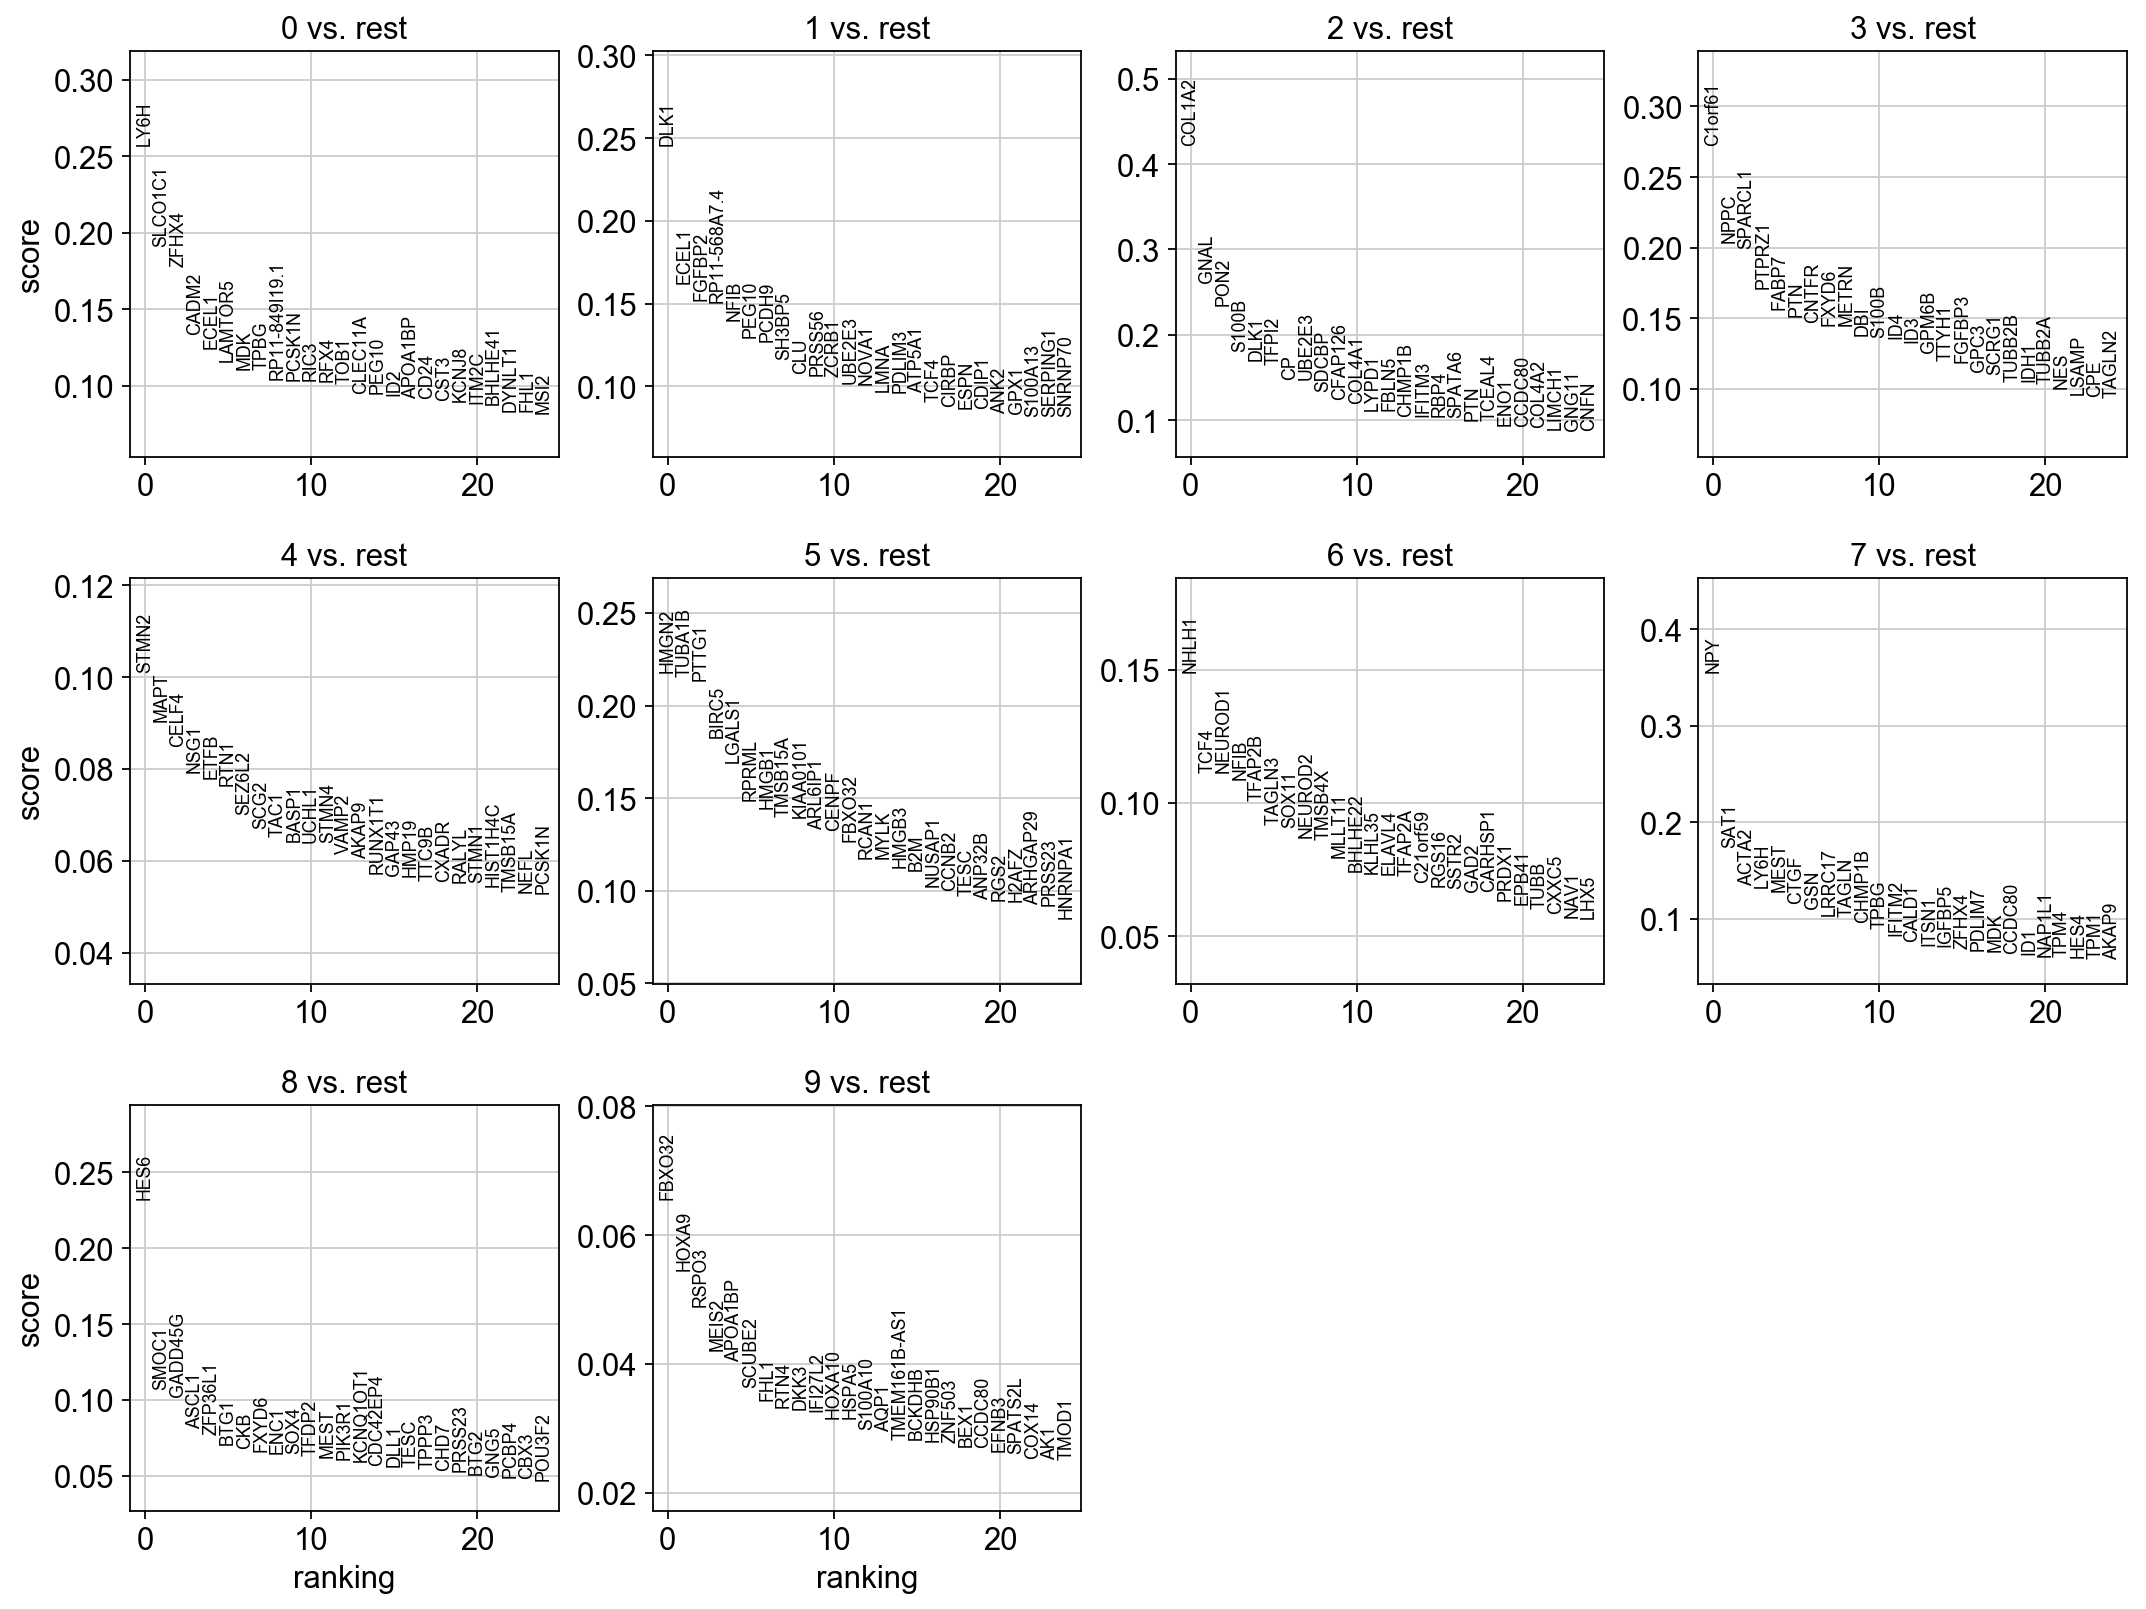

In [184]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [185]:
marker_genes = ['NRXN1','MEF2C','RELN','SOX11','SYT4','SNAP25','FOXP2']

In [189]:
adata = sc.read(results_file)

In [190]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0      1       2        3       4       5       6       7      8  \
0     LY6H   DLK1  COL1A2  C1orf61   STMN2   HMGN2  MLLT11     NPY   HES6   
1    ZFHX4  NOVA1    PON2      PTN   MAP1B   HMGB1  TMSB4X    SAT1   BTG1   
2  SLCO1C1  PEG10    GNAL    GPM6B  MLLT11  TUBA1B    SOX4    MEST   SOX4   
3     SAT1  RPS16   TFPI2   PTPRZ1   BASP1   BIRC5   SOX11  NAP1L1  SMOC1   
4      MDK  RPS19  UBE2E3      DBI   STMN1   PTTG1   NHLH1     GSN  ASCL1   

         9  
0   FBXO32  
1    HOXA9  
2    MEIS2  
3  APOA1BP  
4    RSPO3

In [191]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n           0_p    1_n           1_p     2_n           2_p      3_n  \
0     LY6H  9.678260e-97   DLK1  1.924747e-61  COL1A2  5.910621e-99  C1orf61   
1    ZFHX4  8.493478e-81  NOVA1  1.737457e-40    PON2  8.761491e-83      PTN   
2  SLCO1C1  1.725088e-75  PEG10  9.452517e-39    GNAL  3.183001e-67    GPM6B   
3     SAT1  3.449307e-73  RPS16  3.105611e-37   TFPI2  4.517715e-66   PTPRZ1   
4      MDK  6.437466e-71  RPS19  5.836672e-37  UBE2E3  3.776783e-64      DBI   

             3_p     4_n            4_p     5_n            5_p     6_n  \
0  2.422674e-124   STMN2  4.335584e-169   HMGN2  7.643681e-104  MLLT11   
1  6.727869e-121   MAP1B  1.394398e-158   HMGB1   6.745050e-89  TMSB4X   
2   2.098635e-89  MLLT11  1.722115e-153  TUBA1B   6.851627e-81    SOX4   
3   2.729400e-69   BASP1  3.940412e-152   BIRC5   1.964578e-73   SOX11   
4   2.806379e-67   STMN1  5.621735e-152   PTTG1   7.643412e-67   NHLH1   

            6_p     7_n           7_p    8_n           8_p      9_n  \
0  2.117968e-66     NPY  4.482947e-48   HES6  5.684747e-43   FBXO32   
1  9.078249e-65    SAT1  4.288730e-28   BTG1  3.246368e-31    HOXA9   
2  1.177241e-61    MEST  8.200832e-26   SOX4  4.091514e-25    MEIS2   
3  7.330048e-61  NAP1L1  1.696688e-21  SMOC1  7.309972e-25  APOA1BP   
4  3.358286e-58     GSN  3.374890e-20  ASCL1  5.841287e-22    RSPO3   

            9_p  
0  2.480382e-07  
1  7.698655e-07  
2  2.246940e-06  
3  2.949034e-06  
4  5.114866e-06

In [192]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')


ranking genes
    finished (0:00:01)


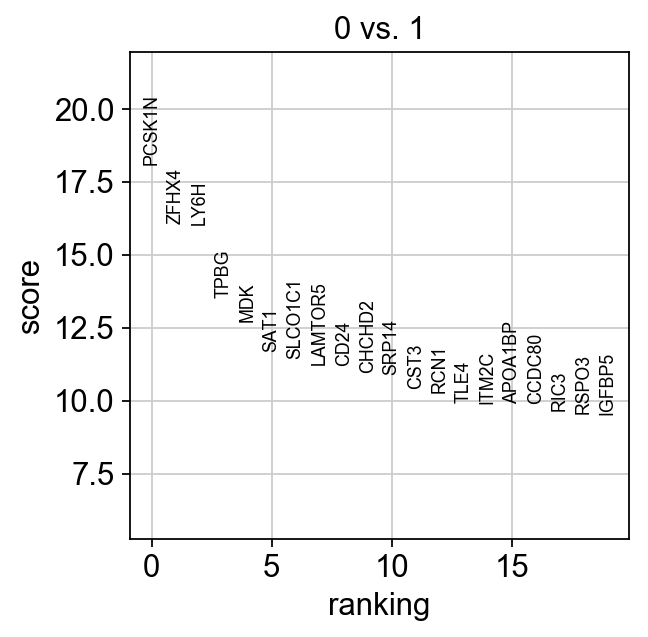

In [193]:
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

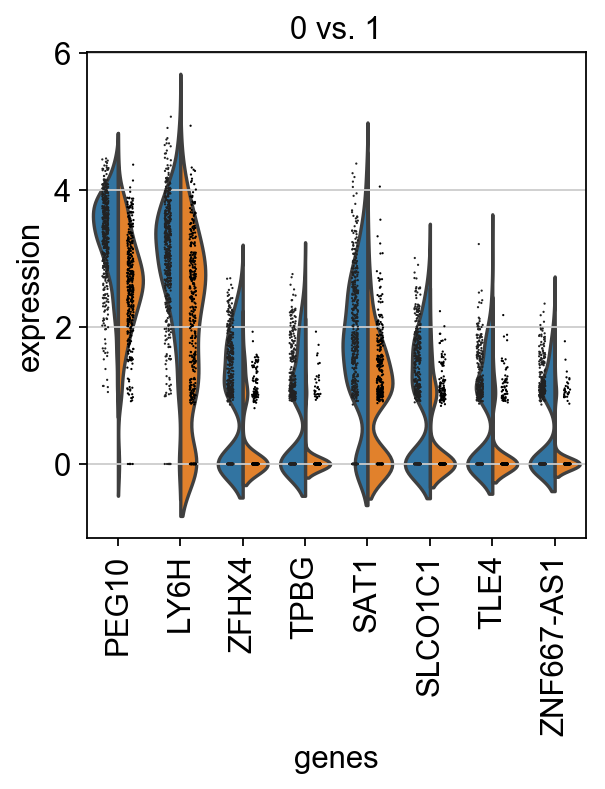

In [121]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [122]:
adata = sc.read(results_file)

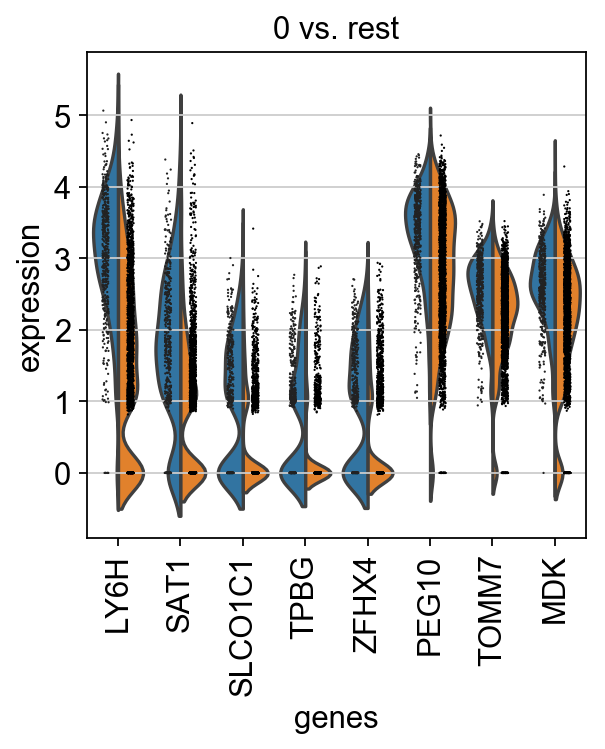

In [123]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

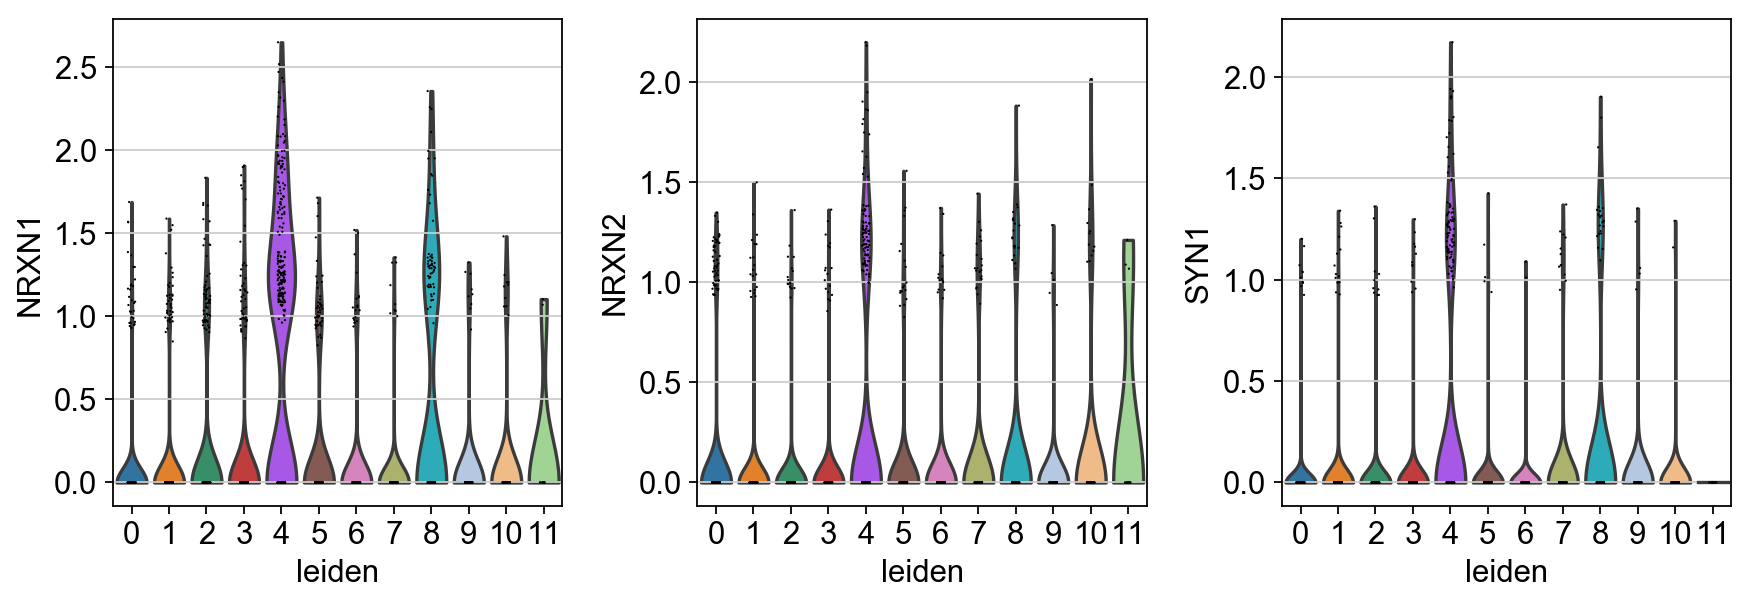

In [124]:
sc.pl.violin(adata, ['NRXN1','NRXN2','SYN1'], groupby='leiden')

In [151]:
new_cluster_names = [
    'C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11']
adata.rename_categories('leiden', new_cluster_names)

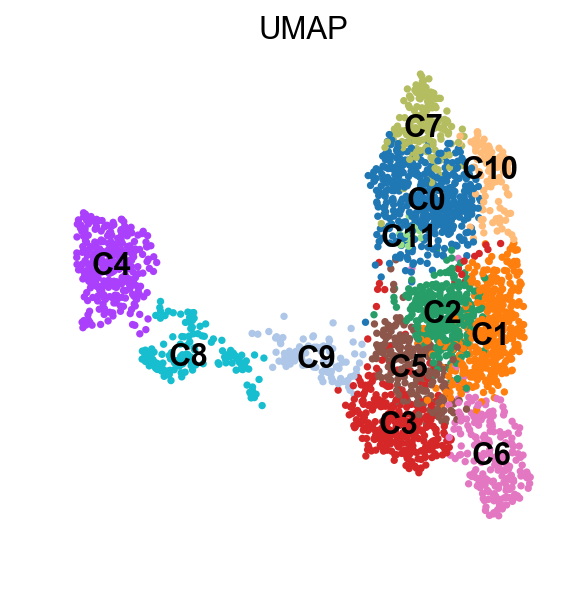

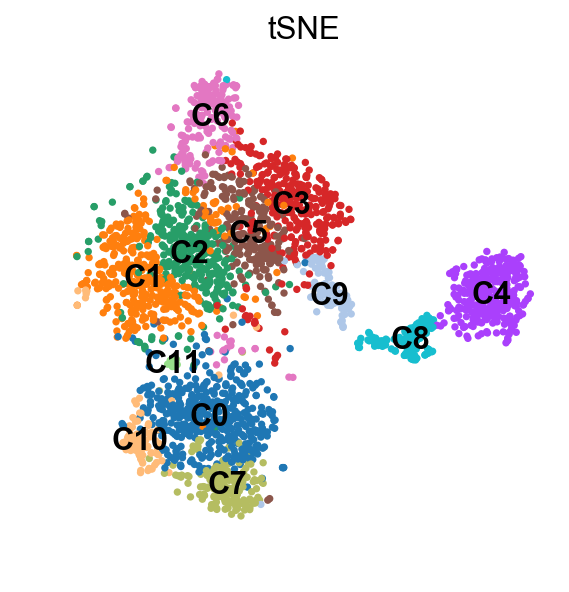

In [153]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='UMAP', frameon=False, save='.pdf')
sc.pl.tsne(adata, color='leiden', legend_loc='on data', title='tSNE', frameon=False, save='.pdf')

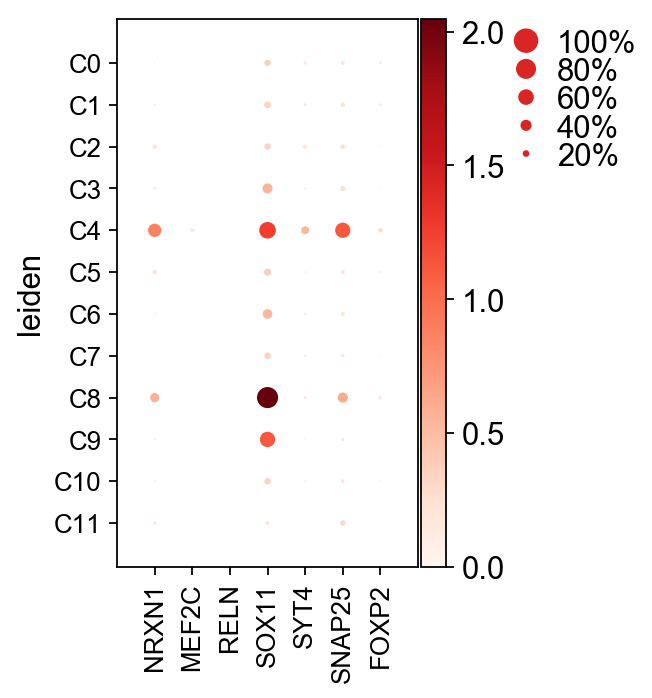

In [134]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='leiden')

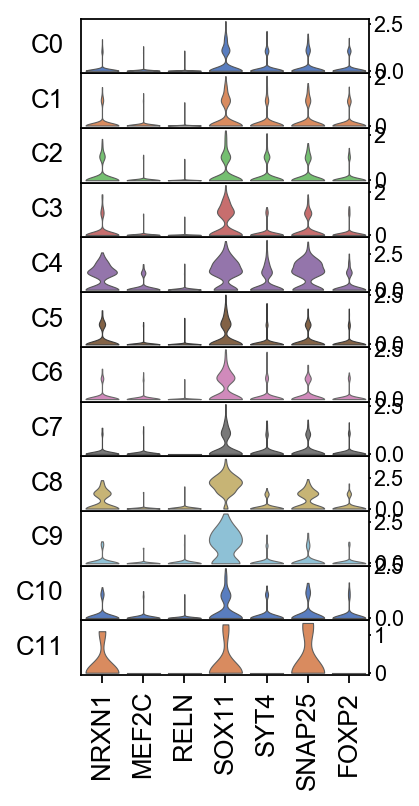

In [135]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)


In [136]:
adata

AnnData object with n_obs × n_vars = 2726 × 20539 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [137]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading